## Predicting Data Contribution of Minecraft Players Using Player Characteristics

### 1. Introduction

Minecraft is a collaborative sandbox game that gives players the freedom to build things from imagination in *Creative Mode*, or explore the world in *Survival Mode*. It is widely known for its distinctive cubic graphics and has gained popularity over all ages and genders, as it encourages creativity and allows players to create their own world.

*The Pacific Laboratory for Artificial Intelligence (PLAI)*, a Computer Science research group at UBC led by Frank Wood, is collecting players' actions data from Minecraft players to study how people play video games. However, running this project presents challenges: the research team needs to  focus their recruitment efforts to attract the right kinds of players and ensure they have sufficient resources, such as software licenses and server capacity, to support the expected number of simultaneous players. This leads to the research question of this project:

*Can player characteristics such as age, experience, and gender predict the amount of data (measured in total played hours) a player contributes?*

### 2. Data Description

Before proceeding with any data description, we will load any packages necessary for data wrangling, analysis, and modeling. Also, we will set the seed to make the results reproducible, ensuring that any random number generated is consistent each time the analysis is ran.

In [1]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidyclust)
library(tidymodels)
library(recipes)

set.seed(5)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard()           masks purrr::discard()
✖ d

A data file called `players.csv` is collected by a research group in Computer Science at UBC, led by Frank Wood, where they set up a MineCraft server to record players' actions as they navigate through the world.

This file is read using the `read_csv()` function and is assigned to an object `players_data`. To explore what information this file contains, `head()` function is used to preview the first sixth rows of the data frame. `players_data` contains data of all unique Minecraft players including the following variables:

- `experience`: *Character* - self-reported experience level of the player (*Pro*,*Veteran*,*Amateur*,*Regular*,*Beginner*)
- `subscribe`: *Logical* - whether the player subscribed to the game-related newsletter (*TRUE*/*FALSE*)
- `hashedEmail`: *Character* - a unique hashed identifier for each player’s email
- `played_hours`: *Double* - total number of hours the player spent on the Minecraft server
- `name`: *Character* - player’s in-game name
- `gender`: *Character* - self-identified gender of the player (*Male*, *Female*, *Non-binary*, *Prefer not to say*, *Agender*, *Two-Spirited*, *Other*)
- `Age`: *Double* - age of the player

`distinct()` function is used to identify all unique values present in `experience` and `gender` variables

There are total of 196 observations and 7 variables in `players_data`. However, there are a few variable that is not used in the analysis, including `subscribe`, `hashedEmail`, and `name`. This is because these variables are irrelevant to the research question and do not contribute meaningful information.

There are few issues in the data that needs to be addressed:
- The variables `experience` and `gender` should be converted to factor types, as they are categorical.
- The variables `hashedEmail` and `name` need to be removed, as they are unnecessary for the analysis and do not provide meaningful information.
- After checking for missing values using `is.na()`, the data contains missing entries, which need to be removed to ensure a complete dataset.
- `gender` categories other than *Male* and *Female* needs to be relabeled as *Other*, since the number of observations for each non-male/female category is too small to analyze separately. (`gender_prop` object shows the number of observations for each `gender` category)


In [2]:
players_data <- read_csv("data/players.csv")

# preview of the data file players
head(players_data)
head(is.na(players_data))

# to see all unique values present in variables
exp_unique <- players_data |> distinct(experience)
gender_unique <- players_data |> distinct(gender)

# number of observation for each gender category
gender_prop <- players_data |>
                group_by(gender) |>
                summarize(count = n())
gender_prop

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


experience,subscribe,hashedEmail,played_hours,name,gender,Age
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


gender,count
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


### 3. Methods and Results

#### 3.1 Data Cleaning

First step of cleaning up the data is removing any unnecessary variables, removing observations that contain NA, converting `experience` and `gender` data type into factor type. This wrangled data is saved in an object called `players`

In [3]:
players <- players_data |>
                select(-subscribe, -hashedEmail, -name) |>
                filter(experience != is.na(experience), played_hours != is.na(played_hours), 
                        gender != is.na(gender), Age != is.na(Age)) |>
                mutate(experience = as_factor(experience))
head(players)

experience,played_hours,gender,Age
<fct>,<dbl>,<chr>,<dbl>
Pro,30.3,Male,9
Veteran,3.8,Male,17
Amateur,0.7,Female,21
Regular,0.1,Male,21
Amateur,0.1,Male,17
Veteran,1.6,Female,23


The next step is to relabel any gender other than *Male* and *Female* into *Other*. This is achieved by filtering the `players` dataset to contain only non-male and non-female observations. Using the `mutate()` function, all these observations are relabeled as *Other*, and this modified data is stored in an object called `other_gender`. Another object called `male_female` is created, which contains only observations labeled as *Male* or *Female*. These two datasets are then combined using `bind_rows()` to form the final cleaned dataseet called `players_clean`. This dataset contains 109 observations and 4 variables.

In [4]:
# turn all genders other than Male and Female into other
other_gender <- players |>
                filter(gender != "Male" & gender != "Female") |>
                mutate(gender = "Other")

# clean data with only male and female
male_female <- players |>
                filter(gender %in% c("Male", "Female")) 

# combine df with only male and female, and df with only other 
players_clean <- bind_rows(male_female, other_gender) |>
                mutate(gender = as_factor(gender)) 

To verify the correctness of this step, the gender distribution was compared before and after the relabeling. Specifically, `gender_prop_clean1` shows the gender counts immediately after removing missing values, while `gender_prop_clean2` shows the counts after relabeling other genders as *Other*. The total number of observations remains consistent, confirming that the relabeling process was ran correctly

In [5]:
# gender distribution after removing NA values
gender_dist_clean1 <- players |>
                group_by(gender) |>
                summarize(count = n())

# gender distribution after relabeling
gender_dist_clean2 <- players_clean |>
                group_by(gender) |>
                summarize(count = n())

gender_dist_clean1
gender_dist_clean2

gender,count
<chr>,<int>
Agender,1
Female,21
Male,75
Non-binary,6
Prefer not to say,5
Two-Spirited,1


gender,count
<fct>,<int>
Male,75
Female,21
Other,13


#### 3.2 Exploratory Data Analysis (EDA)

Summary statistics for all relevant variables are calculated. For categorical variables such as `gender` and `experience`, proportions were computed. For numerical variables including `played_hours` and `Age`, key descriptive statistics including mean, median, standard deviation, minimum, and maximum are calculated to understand the distribution and spread of the data

The proportions of `experience` and `gender` are determined by first using `group_by()` to group rows by each category and then using `summarize()` to calculate the count and percentage for each group.  

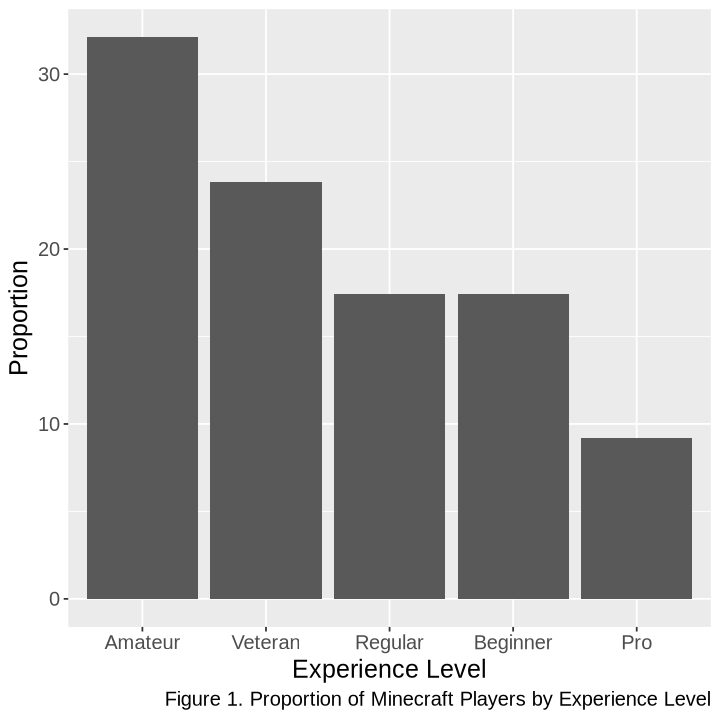

In [6]:
num_obs <- nrow(players_clean)

# experience proportion
experience_prop <- players_clean |>
                group_by(experience) |>
                summarize(count = n(),
                          percentage = n() / num_obs * 100)

options(repr.plot.width = 6, repr.plot.height = 6)
experience_prop_plot <- experience_prop |>
                        ggplot(aes(x = fct_reorder(experience, percentage, .desc = TRUE), y = percentage)) +
                        geom_bar(stat = "identity") +
                        xlab("Experience Level") +
                        ylab("Proportion") +
                        theme(text = element_text(size = 15)) + 
                        labs(caption = "Figure 1. Proportion of Minecraft Players by Experience Level")
experience_prop_plot

According to Figure 1, the most common experience level among players is *Amateur*, making up approximately 32% of the dataset. This is followed by *Veteran* players at 24%, while *Beginner* and *Regular* players each make up around 17% of the player base. *Pro* players form the smallest group, accounting for only 9% of the dataset.

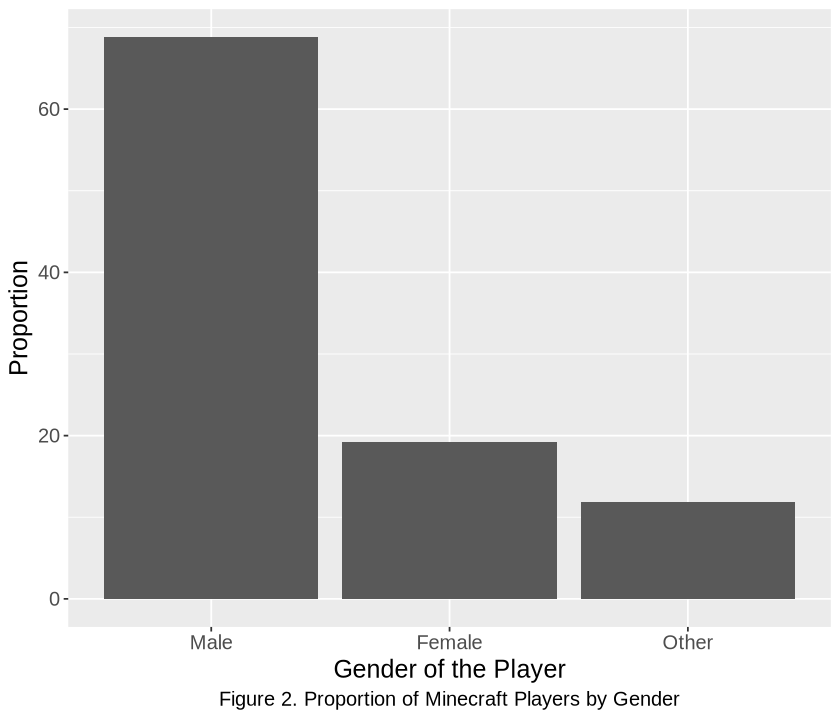

In [7]:
# gender proportion
gender_prop <- players_clean |>
                group_by(gender) |>
                summarize(count = n(),
                          percentage = n() / num_obs * 100)

options(repr.plot.width = 7, repr.plot.height = 6)
gender_prop_plot <- gender_prop |>
                        ggplot(aes(x = fct_reorder(gender, percentage, .desc = TRUE), y = percentage)) +
                        geom_bar(stat = "identity") +
                        xlab("Gender of the Player") +
                        ylab("Proportion") +
                        theme(text = element_text(size = 15), plot.caption = element_text(hjust = 0.5, size = 12)) +
                        labs(caption = "Figure 2. Proportion of Minecraft Players by Gender")

gender_prop_plot

Based on Figure 2., the most common gender among players is *Male*, making up approximately 69% of the dataset. This is followed by *Female* players at 19%. *Other* players is only around 12% of the dataset.

In [8]:
# played hours summary statistic
played_hours_stat <- players_clean |>
                    summarize(mean = mean(played_hours),
                              median = median(played_hours),
                              min = min(played_hours),
                              max = max(played_hours),
                              SD = sd(played_hours))
played_hours_stat

mean,median,min,max,SD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10.50917,0.5,0.1,223.1,37.4496


The summary statistics for `played_hours` indicate that the average playtime is 10.5 hours, with a median of 0.5 hours. The minimum recorded playtime is 0.1 hours, while the maximum is significantly higher at 223 hours. The large gap between the minimum and maximum, combined with a relatively high standard deviation, suggests that there are a few players who have contributed an unusually large number of hours compared to the rest.

In [9]:
# age summary statistic
age_stat <- players_clean |>
            summarize(mean = mean(Age),
                      median = median(Age),
                      min = min(Age),
                      max = max(Age),
                      SD = sd(Age))
age_stat

mean,median,min,max,SD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20.56881,19,8,49,6.422425


For `Age`, the average player age is around 21, with a median of 19 years old. The age range spans from 8 to 49 years old, showing a diverse player base. The standard deviation suggests moderate variability in age. Most players appear to be relatively young, which aligns with the age distribution observed in the exploratory scatter plots.

The mean hours of gameplay for each gender were calculated to determine which gender contributes the most on average. This analysis helps identify whether certain genders are generally more engaged.

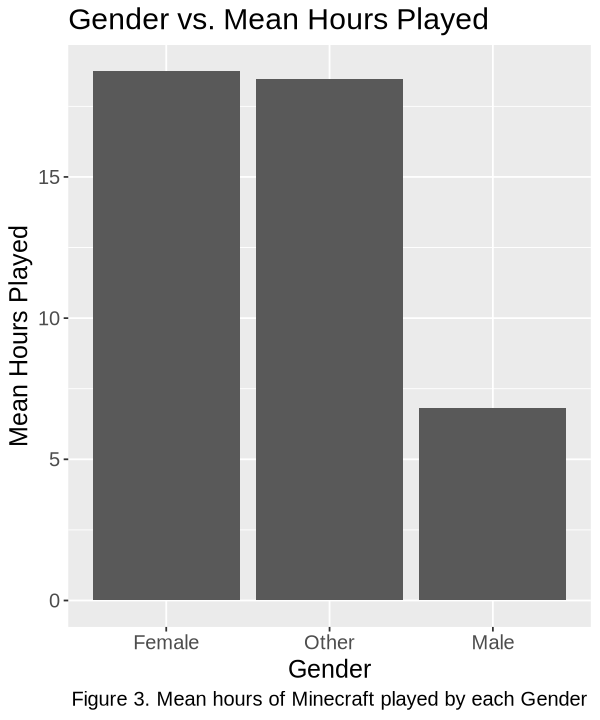

In [10]:
# mean played hours by gender
mean_hours_gender <- players_clean |>
                    group_by(gender) |>
                    summarize(mean_played_hours = mean(played_hours))

options(repr.plot.width = 5, repr.plot.height = 6)
gender_vs_mean_hrs <- mean_hours_gender |>
           ggplot(aes(x = fct_reorder(gender, mean_played_hours, .desc = TRUE), y = mean_played_hours)) +
           geom_bar(stat = "identity") +
           xlab("Gender") +
           ylab("Mean Hours Played") +
           ggtitle("Gender vs. Mean Hours Played") +
           labs(caption = "Figure 3. Mean hours of Minecraft played by each Gender") +
           theme(text = element_text(size = 15), plot.caption = element_text(hjust = 0.5, size = 12)) 
           
gender_vs_mean_hrs

Figure 3 shows that female and other-gender players contribute significantly more gameplay hours on average compared to male players. This suggests that, although males may make up a larger portion of the player base, female and other-gender players tend to be more engaged individually.

Additionally, mean hours played were calculated for each experience level to identify whether certain experience groups are more engaged.

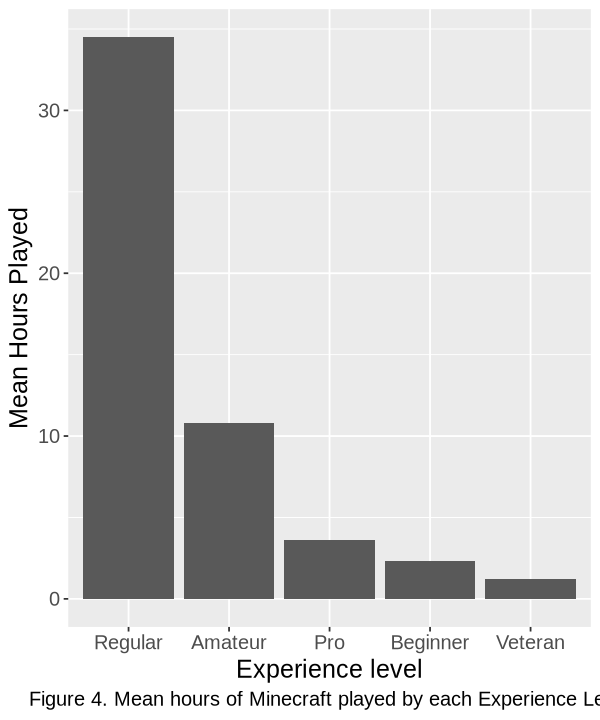

In [11]:
# mean played hours by experience
mean_hours_experience <- players_clean |>
                    group_by(experience) |>
                    summarize(mean_played_hours = mean(played_hours))

exp_vs_mean_hrs <- mean_hours_experience |>
    ggplot(aes(x = fct_reorder(experience, mean_played_hours, .desc = TRUE), y = mean_played_hours)) +
           geom_bar(stat = "identity") +
           xlab("Experience level") +
           ylab("Mean Hours Played") +
           theme(text = element_text(size = 15), plot.caption = element_text(hjust = 0.5, size = 12)) +
           labs(caption = "Figure 4. Mean hours of Minecraft played by each Experience Level") 
exp_vs_mean_hrs

Figure 4 shows that Regular players contribute the highest average gameplay hours, followed by Amateur players. Pro and Veteran players have much lower mean playtimes compared to Regular players, suggesting that high contribution is not necessarily related to higher experience levels.

A proportionally stacked bar plot was created to explore how the experience levels are distributed within each gender group. Unlike total contribution, this plot focuses on the relative composition of experience levels within each gender to help identify whether certain experience groups are more common among specific genders.

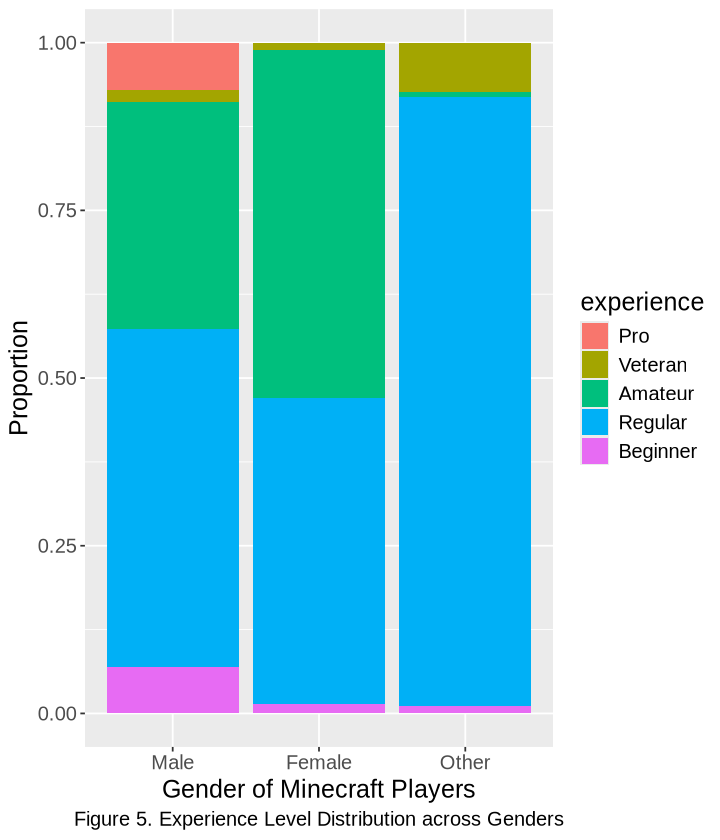

In [12]:
options(repr.plot.width = 6, repr.plot.height = 7)
gender_vs_hrs <- players_clean |>
    ggplot(aes(x = gender, y = played_hours, fill = experience)) +
           geom_bar(stat = "identity", position = "fill") +
           xlab("Gender of Minecraft Players") +
           ylab("Proportion") +
           theme(text = element_text(size = 15), plot.caption = element_text(hjust = 0.5, size = 12)) +
           labs(caption = "Figure 5. Experience Level Distribution across Genders")
gender_vs_hrs

Figure 5 shows that Regular players make up the largest proportion within each gender group, especially among players who identify as "Other." Female players have a higher proportion of Amateur players compared to males and other genders, while Pro players are predominantly male.

Lastly, a scatterplot is created to investigate there is a relationship between a player’s age and their gameplay contribution. Since `hours_played` scale is much larger than `Age` scale, a log scale was applied to the y-axis.

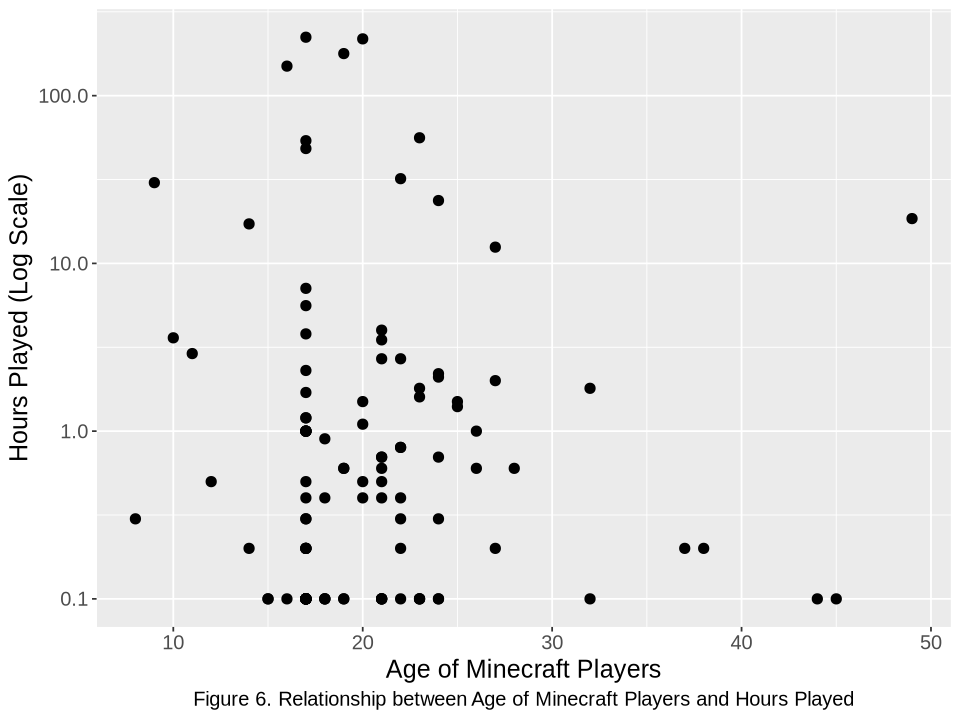

In [13]:
# relationship between age of players and played hours
options(repr.plot.width = 8, repr.plot.height = 6)
age_vs_hrs_1 <- players_clean |>
                ggplot(aes(x = Age, y = played_hours)) +
                geom_point(size = 2.5) +
                labs(x = "Age of Minecraft Players",
                     y = "Hours Played (Log Scale)") +
                scale_y_log10() +
                theme(text = element_text(size = 15), plot.caption = element_text(hjust = 0.5, size = 12)) +
                labs(caption = "Figure 6. Relationship between Age of Minecraft Players and Hours Played")

age_vs_hrs_1

According to Figure 6, there is no clear linear relationship between age and hours played. Most players tend to have relatively low playtime regardless of age, but there are no distinct trends or patterns. Hours played is highly variable suggesting that it may depend on factors other than age.

#### 3.3 Modeling

Based on the exploratory data analysis, there is no clear linear relationship between age and hours played, and large variation in `hours_played` exists across all genders and experience levels.

These patterns suggest that player contribution behavior cannot be easily explained by a single variable or through simple regression analysis. Instead, it is likely that distinct player types exist based on a combination of age and hours played.

To uncover these player groups, K-means clustering is selected as a model to analyze `players_clean` data. This model can identify natural groupings within the data by placing players into clusters based on their similarities in age and gameplay hours. Through this process, we can find the kinds of players who tend to contribute more gameplay data (high `hours_played`), which can help guide recruitment strategies.

Before proceeding with the model, it is important to standardize the data because k-means clustering relies on Euclidean distance, which is sensitive to the scale of the variables. Additionally, k-means clustering only works with numerical predictors. Lastly, we need to tune the model to select the optimal number of clusters (K) by identifying the elbow point where the within-cluster sum of squares (WSSD) significantly decreases.

The following code guides the process of tune the model to choose the optimal number of K.

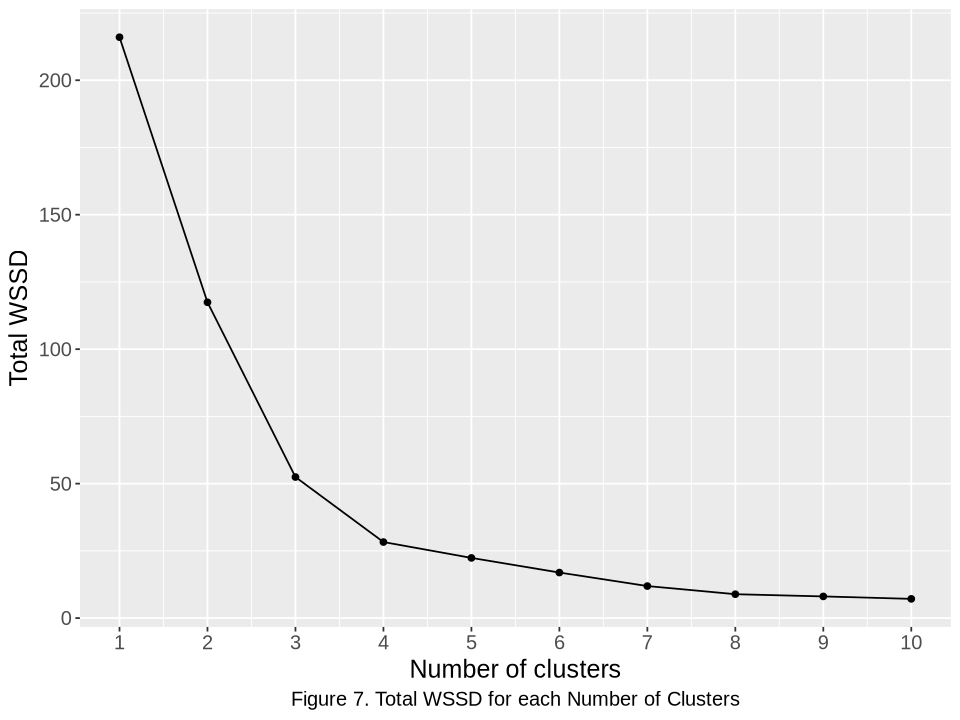

In [14]:
# K-means recipe
kmeans_recipe <- recipe(~ Age + played_hours, data = players_clean) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

# store possible K-values in a dataframe
k_vals <- tibble(num_clusters = 1:10)

# model spec for tuning K
kmeans_spec_tune <- k_means(num_clusters = tune()) |>
                set_engine("stats", nstart = 100) 

# calculate total_WSSD for each K
kmeans_results <- workflow() |>
                add_recipe(kmeans_recipe) |>
                add_model(kmeans_spec_tune) |>
                tune_cluster(resamples = apparent(players_clean), grid = k_vals) |>
                collect_metrics() |>
                filter(.metric == "sse_within_total") |>
                mutate(total_WSSD = mean) |>
                select(num_clusters, total_WSSD)

# Plot elbow plot - Total_WSSD vs num_clusters
elbow_plot <- kmeans_results |>
            ggplot(aes(x = num_clusters, y = total_WSSD)) +
            geom_point() +
            geom_line() +
            xlab("Number of clusters") +
            ylab("Total WSSD") +
            theme(text = element_text(size = 15), plot.caption = element_text(hjust = 0.5, size = 12)) +
            labs(caption = "Figure 7. Total WSSD for each Number of Clusters") +
            scale_x_continuous(breaks = 1:10)
elbow_plot

Based on Figure 7, K = 4 is selected as the number of clusters. This is the point where the within-cluster sum of squares (WSSD) shows a significant decrease compared to previous K values, but the rate of decrease levels off after K = 4. This suggests that adding more clusters beyond this point would result in minimal improvement in clustering performance, indicating that four clusters will capture the optimal clustering groups.

Now, the optimal K value to cluster the data points. 

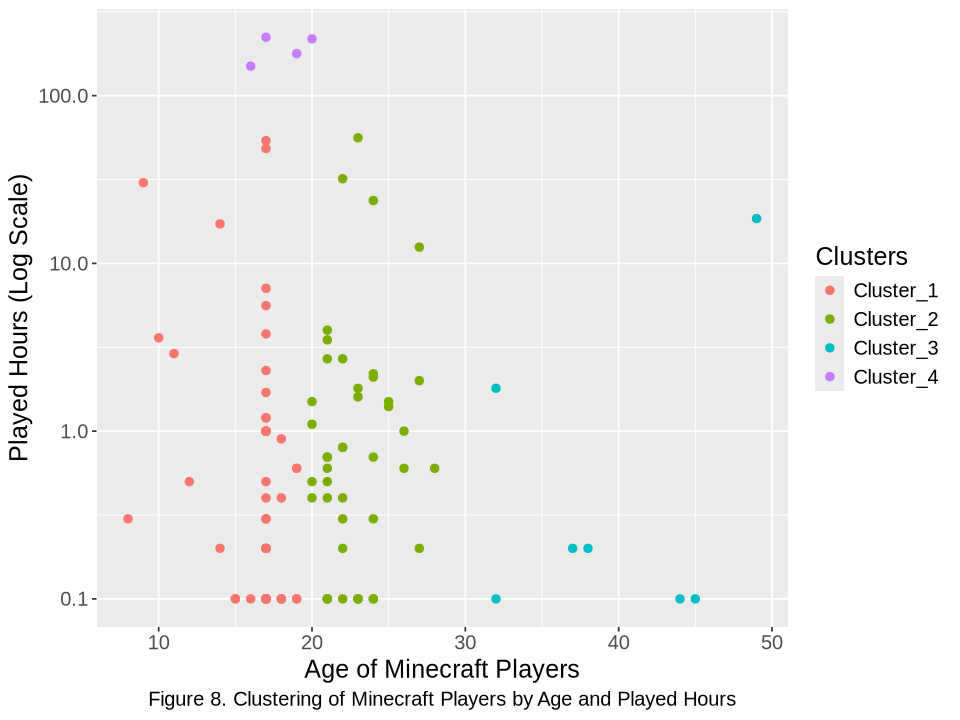

In [15]:
# reset model with chosen K
kmeans_spec <- k_means(num_clusters = 4) |>
            set_engine("stats", nstart = 10)

# fit the model
kmeans_fit <- workflow() |>
            add_recipe(kmeans_recipe) |>
            add_model(kmeans_spec) |>
            fit(players_clean)

# augment original data frame with cluster assignments 
clustered_data <- kmeans_fit |>
                augment(players_clean) 

# plot clustered data
options(repr.plot.width = 8, repr.plot.height = 6)
clustered_plot <- clustered_data |>
                ggplot(aes(x = Age, y = played_hours, color = .pred_cluster)) +
                geom_point(size = 2) +
                labs(x = "Age of Minecraft Players", 
                     y = "Played Hours (Log Scale)",
                     color = "Clusters")+
                theme(text = element_text(size = 15), plot.caption = element_text(hjust = 0.5, size = 12)) +
                labs(caption = "Figure 8. Clustering of Minecraft Players by Age and Played Hours") +
                scale_y_log10()

clustered_plot

According to Figure 8, there are four clusters visible:
- Cluster 1: Younger players (age < 20) with low to moderate playtime.
- Cluster 2: Slightly older players (20 < age < 30) with low to moderate playtime.
- Cluster 3: Older players (age > 30) generally contributing fewer hours, with a few exceptions.
- Cluster 4: Outliers with exceptionally high playtime, mostly in a younger age group (15 < age < 20).

### 4. Discussion

After identifying four distinct clusters using the K-means algorithm, we further examined the composition of each cluster based on gender and experience level.

`summarise()` has grouped output by '.pred_cluster'. You can override using the
`.groups` argument.


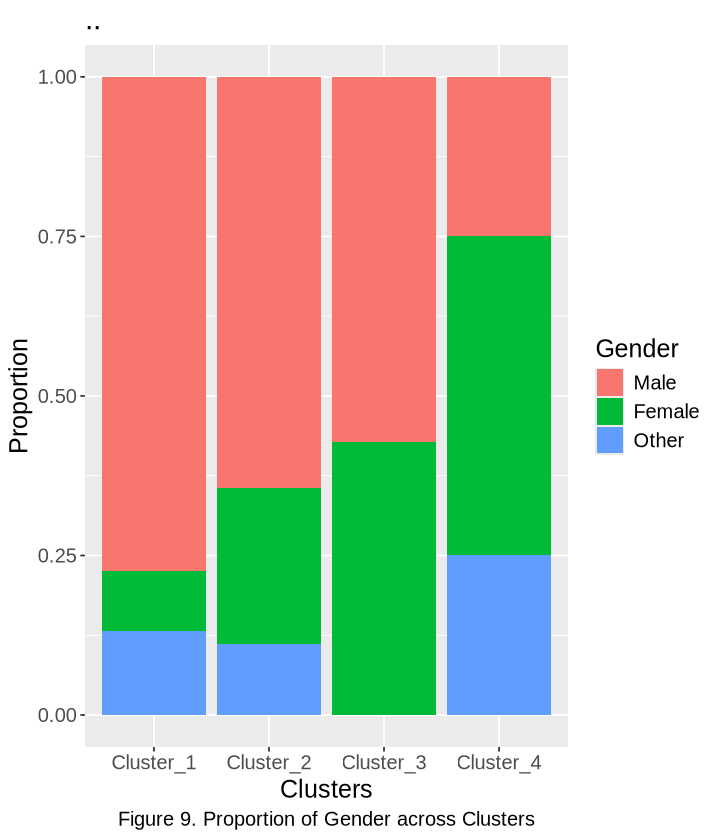

In [16]:
# examine demographic composition of each cluster based on gender
gender_cluster <- clustered_data |>
  group_by(.pred_cluster, gender) |>
  summarize(count = n())

options(repr.plot.width = 6, repr.plot.height = 7)
gender_cluster_plot <- gender_cluster |>
                    ggplot(aes(x = .pred_cluster, y = count, fill = gender)) +
                    geom_bar(stat = "identity", position = "fill") +
                    labs(x = "Clusters", y = "Proportion",
                         fill = "Gender", title = "..") +
                    theme(text = element_text(size = 15), plot.caption = element_text(hjust = 0.5, size = 12)) +
                    labs(caption = "Figure 9. Proportion of Gender across Clusters") 

gender_cluster_plot

Figure 9 suggests that Cluster 1 and 2 are predominantly male players where Cluster 2 shows a slight increase in female representation compared to Cluster 1. Additionally, Cluster 3 demonstrates a more balanced distribution between male and female players. Finally, Cluster 4 shows a shift where female players make up the majority, and the proportion of other genders is also higher.

`summarise()` has grouped output by '.pred_cluster'. You can override using the
`.groups` argument.


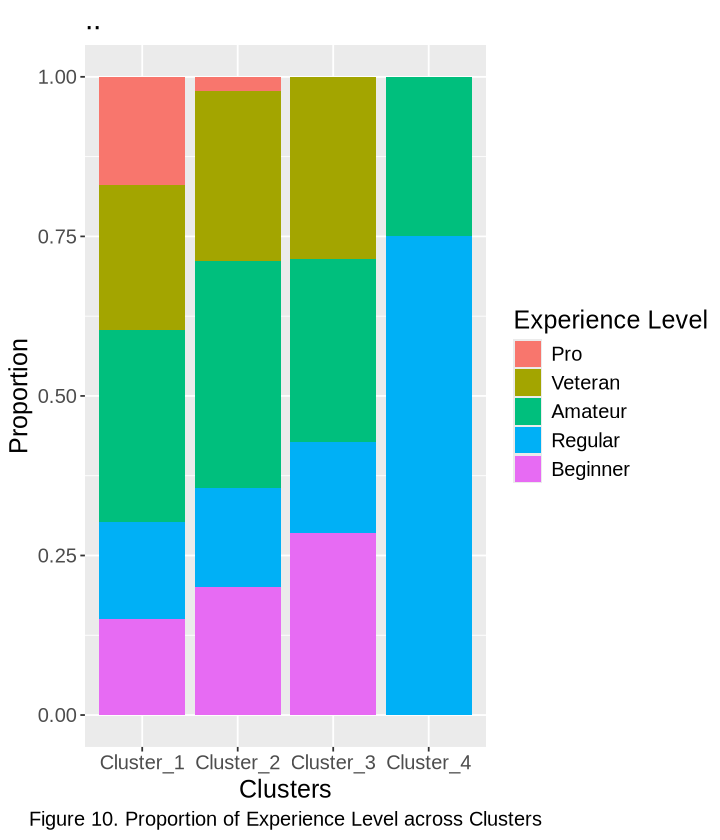

In [17]:
# examine demographic composition of each cluster based on experience level
exp_cluster <- clustered_data |>
  group_by(.pred_cluster, experience) |>
  summarize(count = n())

exp_cluster_plot <- exp_cluster |>
                    ggplot(aes(x = .pred_cluster, y = count, fill = experience)) +
                    geom_bar(stat = "identity", position = "fill") +
                    labs(x = "Clusters", y = "Proportion",
                         fill = "Experience Level", title = "..") +
                    theme(text = element_text(size = 15), plot.caption = element_text(hjust = 0.5, size = 12)) +
                    labs(caption = "Figure 10. Proportion of Experience Level across Clusters")

exp_cluster_plot

Figure 10 shows that Cluster 1 consists mainly of Pro, Veteran, and Amateur players, indicating a group with higher prior gaming experience. Clusters 2 and 3 are dominated by Amateur and Veteran players, showing a blend of moderate to experienced players. Cluster 4 is mostly composed of Regular players, suggesting that this group is consistently engaged with the game.

These are the findings based on proportional plots (Figure 9 and 10) on top of the player types identified by K-means:
- Clusters 1 and 2: Predominantly male and contain more experienced players, potentially representing high-contribution group.
- Cluster 4: Primarily female and other genders with mostly Regular players, indicating consistent but less intense contribution.
- Cluster 3: A cluster with more gender diversity and a balanced mix of experience levels.

High-contributing players types are Cluster 1 and 2 with age range of 10 to 30. Additionally, Cluster 1 and 2 are predominantly male and composed of more experienced players (Pro, Veteran, Amateur). Cluster 4 has a high played hours; however, there are not enough points in the particular cluster to be confident about this result comparing with other clusters.

These findings suggest that age range of 10 to 30, experienced male players is the target group that spends the large amount of hours playing Mincraft, thus contributing the most data.